## Decision Trees

**Objective**: This notebook follows the workflow from the logistic regression notebook to analyse customer reviews using Decision Tree classifiers to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed A Grid search to find the optimal setup for a Decision Tree on both the balanced and unbalanced data. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset and compare the results.

**Key Findings**:

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, auc

from source import downsample_binary, my_tokenizer
import joblib


In [16]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

## Decision trees on the vectorized reviews
I will first downsample the train data as before, then optimize a decision tree model on the unbalanced data first, then the balanced data with a downsampled majority class and finally compare the results.

In [17]:
# reading in the data
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")

In [18]:
# test train split before doing the downsampling
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
test_later = X_test

In [20]:
# function which downsamples the majority class in a dataframe

balanced_set = downsample_binary(y_train, X_train)

In [21]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [22]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]


Now we can scale the data we have. We use seperate StandardScalers for each dataset. We will use the scaled data in the model evaluation phase.

### Optimizing a Decision Tree Classifier on the original unbalanced data

I will use a grid search to find the best combination of:
- criterion: gini, entropy, (log_loss)
- max_depth
- min_samples_split
- min_samples_leaf
- max_features


In [23]:
estimators = [
              ('model', DecisionTreeClassifier(random_state=12))]


pipe = Pipeline(estimators)

In [24]:

params = {'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [5,10,15],
    'model__min_samples_leaf': [3,5]
    # 'model__min_samples_split':[5,10]
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [ ]:
fitted_tree = grid_search.fit(X_train, y_train)

In [22]:
fitted_tree.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=3, random_state=12))],
         verbose=True)

In [16]:

params2 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [15,25],
    'model__min_samples_leaf': [3,5]
    # 'model__min_samples_split':[5,10],

    
    
}

grid_search2 = GridSearchCV(pipe, param_grid=params2, verbose=3, n_jobs=2)

In [ ]:
fitted_tree2 = grid_search2.fit(X_train,y_train)

In [19]:
print(fitted_tree2.best_estimator_)

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)


In [40]:

params3 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [25,50],
    'model__min_samples_leaf': [5,10]
    # 'model__min_samples_split':[5,10],

    
    
}

grid_search3 = GridSearchCV(pipe, param_grid=params3, verbose=3, n_jobs=2)

In [ ]:
fitted_tree3 = grid_search3.fit(X_train,y_train)

In [42]:
fitted_tree3.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)

In [54]:

params4 = {'normalise': [StandardScaler()],
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [24,25,26],
    'model__min_samples_leaf': [5]    
}

grid_search4 = GridSearchCV(pipe, param_grid=params4, verbose=3, n_jobs=2)

In [ ]:
fitted_tree4 = grid_search4.fit(X_train, y_train)


In [56]:
fitted_tree4.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)

In [25]:
estimators= [('vectorize', combined_features),
              ('model', DecisionTreeClassifier(max_depth=25, criterion="entropy", min_samples_leaf=5,random_state=12))]
pipe_final = Pipeline(estimators, verbose = True)

pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 4.1min
[Pipeline] ............. (step 2 of 2) Processing model, total=  30.3s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x151e6d700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x151e6d700>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        min_samples_leaf=5, random_state=12))],
         verbose=True)

### Optimizing a Decision Tree Classifier on the balanced data
Using the data with randomly downsampled majority class
I will use a grid search to find the best combination of:
- max_depth
- min_samples_split
- min_samples_leaf - turns out to be default


In [24]:
estimators_bal = [
              ('model', DecisionTreeClassifier(random_state=12))]
pipe_bal = Pipeline(estimators_bal)


In [25]:

params_bal = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [5,10,15],
    'model__min_samples_leaf': [3,5]
    # 'model__min_samples_split':[5,10],

    
    
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [ ]:
fitted_tree_bal = grid_search_bal.fit(X_train_bal, y_train_bal)

In [28]:
fitted_tree_bal.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=5, random_state=12))])

In [29]:

params_bal2 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [15,20,25,30],
    'model__min_samples_leaf': [5]
    # 'model__min_samples_split':[5,10],

    
    
}

grid_search_bal2 = GridSearchCV(pipe_bal, param_grid=params_bal2, verbose=3, n_jobs=2)

In [ ]:
fitted_tree_bal2 = grid_search_bal2.fit(X_train_bal, y_train_bal)

In [32]:
print(fitted_tree_bal2.best_estimator_)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=30,
                                        min_samples_leaf=5, random_state=12))])


In [43]:

params_bal4 = {
    'model__criterion': ["entropy"],
    'model__random_state':[12],
    'model__max_depth': [35,40,50],
    'model__min_samples_leaf': [10]
    # 'model__min_samples_split':[5,10],

    
    
}

grid_search_bal4 = GridSearchCV(pipe_bal, param_grid=params_bal4, verbose=3, n_jobs=2)

In [ ]:
fitted_tree_bal4 = grid_search_bal4.fit(X_train_bal, y_train_bal)

In [45]:
fitted_tree_bal4.best_estimator_

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=10,
                                        random_state=12))])

In [46]:
fitted_tree_bal4.best_score_

0.7557870711235459

In [26]:
estimators_final_bal= [('vectorize', combined_features),
              ('model', DecisionTreeClassifier(max_depth=40, criterion="entropy", min_samples_leaf=10,random_state=12))]
pipe_final_bal = Pipeline(estimators_final_bal, verbose = True)

pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 2.0min
[Pipeline] ............. (step 2 of 2) Processing model, total=  20.6s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x151e6d700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x151e6d700>))])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=10,
                                        random_state=12))],
         verbose=True)

We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [28]:
y_train_predicted = pipe_final.predict(X_train_unvec)
y_test_predicted = pipe_final.predict(X_test_unvec)
train_acc_unbal = accuracy_score(y_train, y_train_predicted)
test_acc_unbal= accuracy_score(y_test, y_test_predicted)
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.46      0.21      0.28     33949
           1       0.79      0.92      0.85    108208

    accuracy                           0.75    142157
   macro avg       0.62      0.56      0.57    142157
weighted avg       0.71      0.75      0.71    142157



In [29]:
y_train_predicted_bal = pipe_final_bal.predict(X_train_bal_unvec)
y_test_predicted_bal = pipe_final_bal.predict(X_test_unvec)
train_acc_bal = accuracy_score(y_train_bal, y_train_predicted_bal)
test_acc_bal= accuracy_score(y_test, y_test_predicted_bal)
print(classification_report(y_test, y_test_predicted_bal))

              precision    recall  f1-score   support

           0       0.47      0.80      0.59     33949
           1       0.92      0.71      0.80    108208

    accuracy                           0.73    142157
   macro avg       0.69      0.76      0.70    142157
weighted avg       0.81      0.73      0.75    142157



In [51]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [27]:
joblib.dump(pipe_final, "../model/decision-tree-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/decision-tree-bal-model.pkl")



['../model/decision-tree-bal-model.pkl']

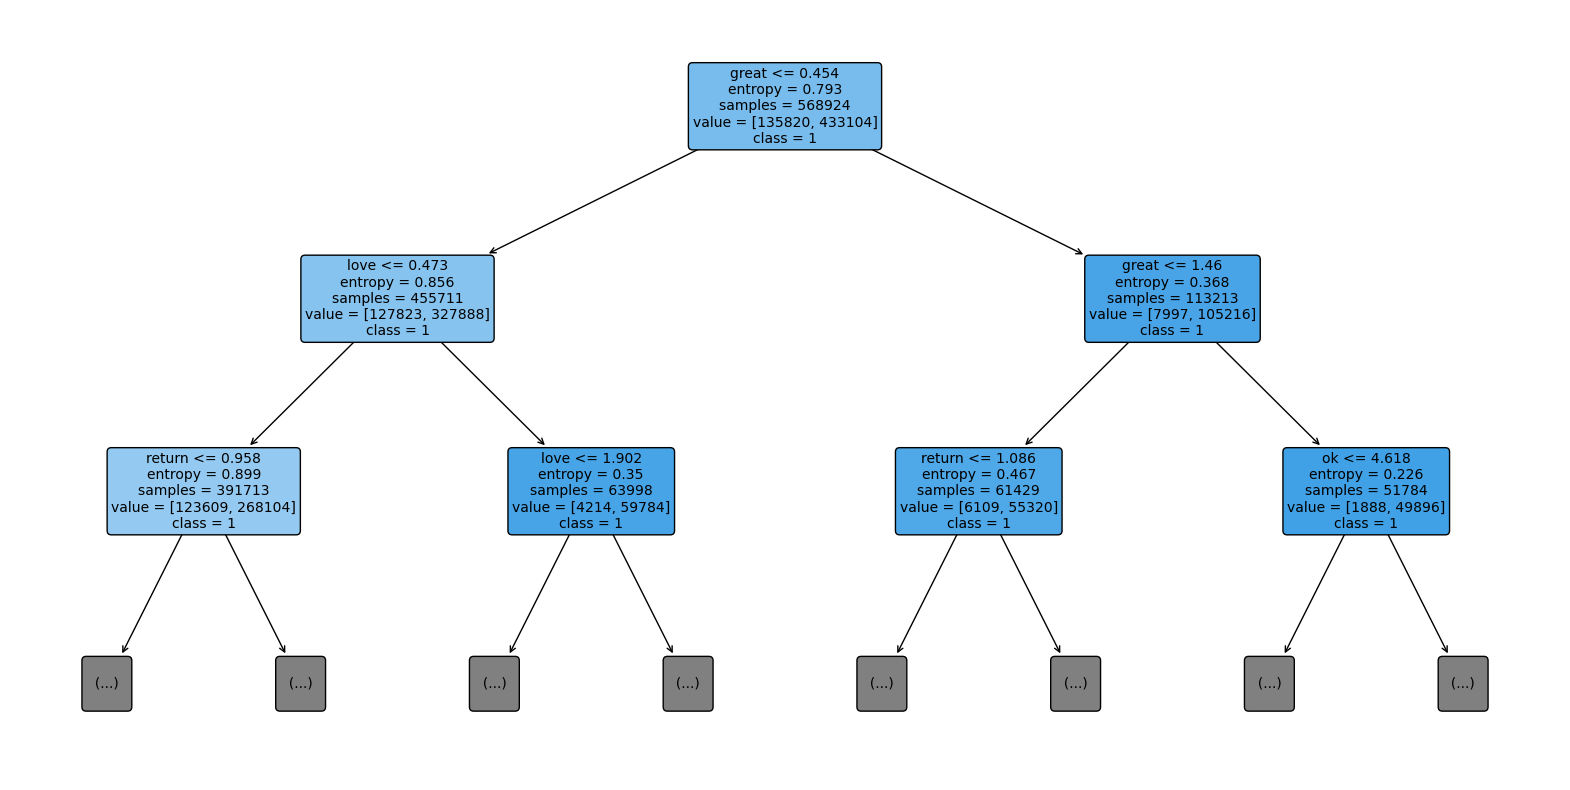

In [18]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier = pipe_final[-1]

plt.figure(figsize=(10, 5))
plot_tree(decision_tree_classifier, max_depth=2, filled=True, feature_names=list(X_train.columns), class_names=["0","1"], rounded=True)
plt.show()

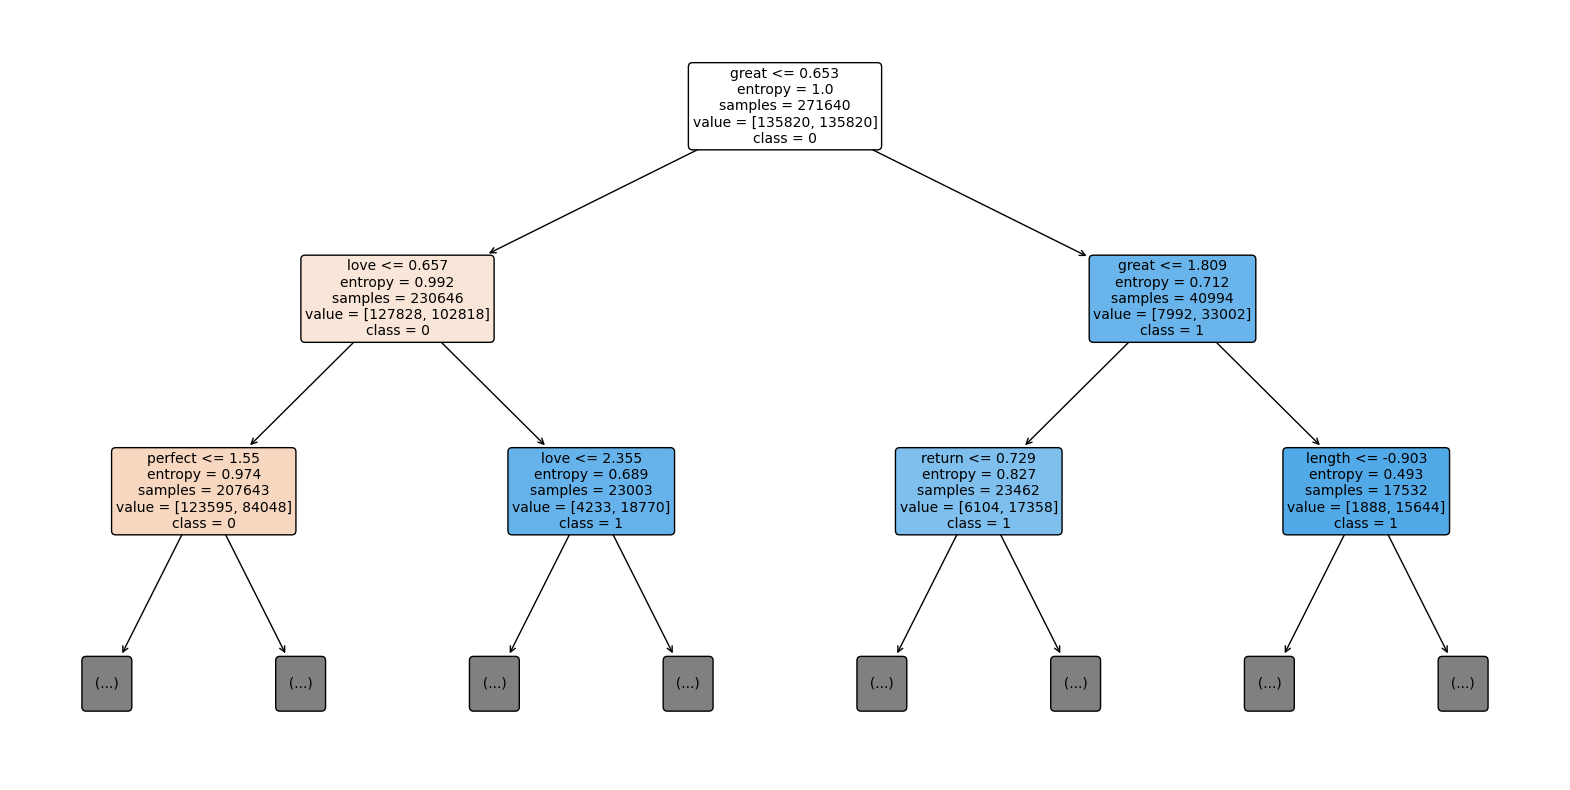

In [19]:
# retrieve the decision tree classifier from the pipeline
decision_tree_classifier_bal = pipe_final_bal[-1]

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier_bal, max_depth=2, filled=True, feature_names=list(X_train.columns), class_names=["0","1"], rounded=True)
plt.show()

In [21]:
# normal
cm_unbal = confusion_matrix(y_test, y_test_predicted)

In [22]:
# downsampled
cm_bal = confusion_matrix(y_test, y_test_predicted_bal)

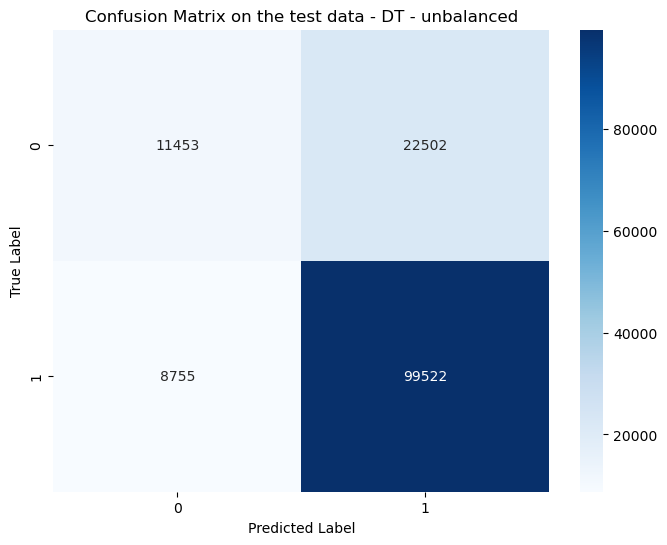

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_unbal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - DT - unbalanced")
plt.show()

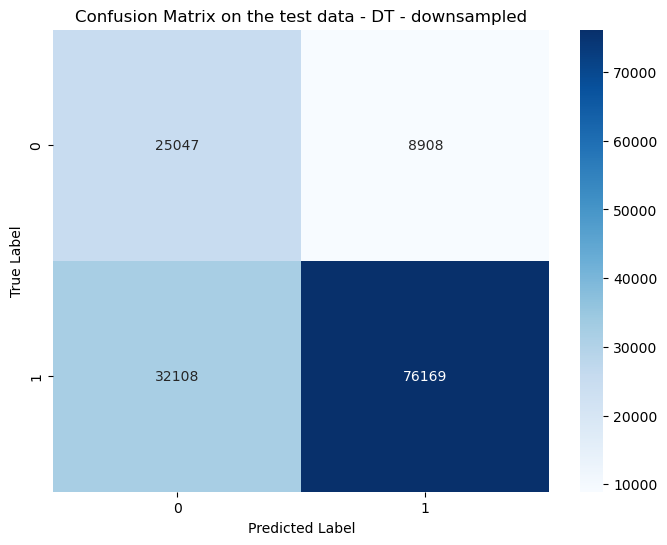

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - DT - downsampled")
plt.show()

In [25]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)
display1 = RocCurveDisplay(fpr=fpr_unbal, tpr=tpr_unbal, roc_auc=roc_auc1, estimator_name='Unbalanced LogReg')

In [26]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)
display2 = RocCurveDisplay(fpr=fpr_bal, tpr=tpr_bal, roc_auc=roc_auc2, estimator_name='Balanced LogReg')

We can see how the ROC changes as we change the confidence thresehold. It shows we could try vary it and compare.

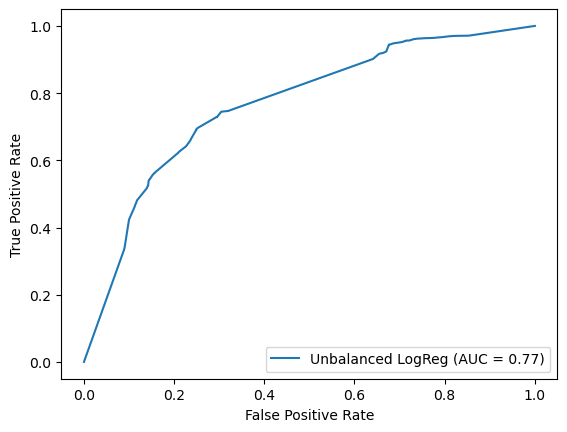

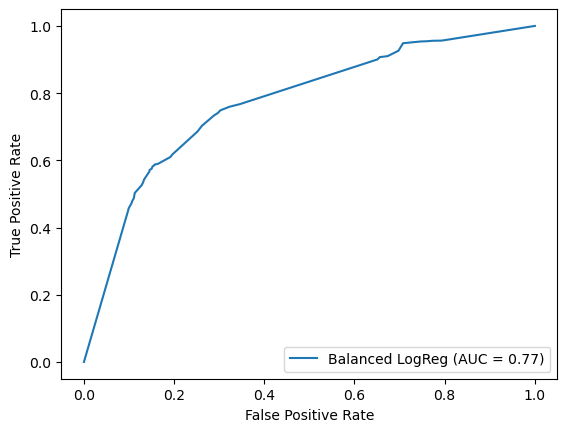

In [27]:
display1.plot()
display2.plot()
plt.show()

In [28]:
y_pred_baseline= decision_tree_classifier.predict(scaler.transform(df[df.columns[5:]]))

incorrect_guesses = df["binary"] != y_pred_baseline
incorrect_v = pd.Series(y_pred_baseline)[incorrect_guesses]
ig = pd.concat([pd.Series(incorrect_v),df[incorrect_guesses]], axis=1)


In [29]:
ig.columns[6:]

Index(['10', '100', '6s', 'abl', 'absolut', 'access', 'actual', 'ad', 'adapt',
       'add',
       ...
       'well made', 'work fine', 'work good', 'work great', 'work like',
       'work perfectli', 'work well', 'would buy', 'would definit',
       'would recommend'],
      dtype='object', length=600)

In [30]:
rev = ig.loc[3]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text[:47]} \n{text[47: ]}")

Actual: 0, Guess: 1, Overall: 2
Review: DON'T CARE FOR IT.  GAVE IT AS A GIFT AND THEY  
WERE OKAY WITH IT.  JUST NOT WHAT I EXPECTED.


In [31]:
feature_values = scaler.transform(ig.loc[3, ig.columns[6:]].values.reshape(1, -1))
fi = decision_tree_classifier.feature_importances_

feature_imp = pd.DataFrame(fi.reshape(1,-1), columns=ig.columns[5:], index=['Importances']).T
sorted_imp = feature_imp.sort_values(by='Importances', ascending=False)

print(sorted_imp.head(10))

           Importances
got           0.136129
love          0.111577
return        0.060886
bright        0.044227
left          0.040747
perfect       0.040642
wast          0.028748
perfectli     0.026919
exactli       0.026765
gold          0.026248


/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


We see that this model is harder to interpret. It is looking for how the top words are weighed even though they don't appear in the review. So the scores for all these words would be 0 but it takes a while til it gets further in the tree. It seems it struggles with this task.